In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from kernel_nn_layer import PolynomialKernelConv

%matplotlib inline
def mkdirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

## LeNet CNN network structure

In [2]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.bn1=nn.BatchNorm2d(10)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.bn2=nn.BatchNorm2d(20)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=self.bn1(x)
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=self.bn2(x)
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)

## LeNet KervolutionNN network structure

In [3]:
class KNNPolyNet(nn.Module):
    def __init__(self):
        super(KNNPolyNet,self).__init__()
        self.conv1=PolynomialKernelConv(1,10,5,cp=1,dp=2)
        self.bn1=nn.BatchNorm2d(10)
        self.conv2=PolynomialKernelConv(10,20,5,cp=1,dp=2)
        self.bn2=nn.BatchNorm2d(20)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=self.bn1(x)
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=self.bn2(x)
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)

## Train, test data loader

In [4]:
train_loader=torch.utils.data.DataLoader(
    datasets.MNIST("data",train=True,download=True,transform=transforms.Compose([
                transforms.ToTensor(),
            ])),batch_size=128,shuffle=True)
test_loader=torch.utils.data.DataLoader(
    datasets.MNIST("data",train=False,download=True,transform=transforms.Compose([
                transforms.ToTensor(),
            ])),batch_size=128,shuffle=False
)
attack_test_loader=torch.utils.data.DataLoader(
    datasets.MNIST("data",train=False,download=True,transform=transforms.Compose([
                transforms.ToTensor(),
            ])),batch_size=1,shuffle=False
)
print(len(train_loader))
print(len(test_loader))

469
79


In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn=CNNNet().to(device)
cnn.train(mode=True)

knn=KNNPolyNet().to(device)
knn.train(mode=True)

KNNPolyNet(
  (conv1): PolynomialKernelConv(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): PolynomialKernelConv(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
criterion=torch.nn.NLLLoss()

## First, train the network, get optimal parameters

In [7]:
def compute_accuray(pred,true):
    pred_idx=pred.argmax(dim=1).detach().cpu().numpy()
    tmp=pred_idx==true.cpu().numpy()
    return sum(tmp)/len(pred_idx)
def train(m,out_dir):
    iter_loss=[]
    train_losses=[]
    test_losses=[]
    iter_loss_path=os.path.join(out_dir,"iter_loss.csv")
    epoch_loss_path=os.path.join(out_dir,"epoch_loss.csv")
    nb_epochs=20
    last_loss=99999
    mkdirs(os.path.join(out_dir,"models"))
    optimizer=optim.SGD(m.parameters(),lr=0.003,momentum=0.9)
    for epoch in range(nb_epochs):
        train_loss=0.
        train_acc=0.
        m.train(mode=True)
        for data,target in train_loader:
            data,target=data.to(device),target.to(device)
            optimizer.zero_grad()
            output=m(data)
            loss=criterion(output,target)
            loss_value=loss.item()
            iter_loss.append(loss_value)
            train_loss+=loss_value
            loss.backward()
            optimizer.step()
            acc=compute_accuray(output,target)
            train_acc+=acc
        train_losses.append(train_loss/len(train_loader))
        
        test_loss=0.
        test_acc=0.
        m.train(mode=False)
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=m(data)
            loss=criterion(output,target)
            loss_value=loss.item()
            iter_loss.append(loss_value)
            test_loss+=loss_value
            acc=compute_accuray(output,target)
            test_acc+=acc
        test_losses.append(test_loss/len(test_loader))
        print("Epoch {}: train loss is {}, train accuracy is {}; test loss is {}, test accuracy is {}".
              format(epoch,round(train_loss/len(train_loader),2),
                     round(train_acc/len(train_loader),2),
                     round(test_loss/len(test_loader),2),
                     round(test_acc/len(test_loader),2)))        
        if test_loss/len(test_loader)<last_loss:      
            save_model_path=os.path.join(out_dir,"models","best_model.tar".format(epoch))
            torch.save({
                    "model":m.state_dict(),
                    "optimizer":optimizer.state_dict()
                },save_model_path)
            last_loss=test_loss/len(test_loader)
        
    df=pd.DataFrame()
    df["iteration"]=np.arange(0,len(iter_loss))
    df["loss"]=iter_loss
    df.to_csv(iter_loss_path,index=False)
    
    df=pd.DataFrame()
    df["epoch"]=np.arange(0,nb_epochs)
    df["train_loss"]=train_losses
    df["test_loss"]=test_losses
    df.to_csv(epoch_loss_path,index=False)    

In [8]:
train(cnn,"lenet-cnn")

Epoch 0: train loss is 1.53, train accuracy is 0.52; test loss is 0.35, test accuracy is 0.94
Epoch 1: train loss is 0.5, train accuracy is 0.85; test loss is 0.13, test accuracy is 0.96
Epoch 2: train loss is 0.33, train accuracy is 0.9; test loss is 0.09, test accuracy is 0.97
Epoch 3: train loss is 0.26, train accuracy is 0.92; test loss is 0.07, test accuracy is 0.98
Epoch 4: train loss is 0.23, train accuracy is 0.94; test loss is 0.06, test accuracy is 0.98
Epoch 5: train loss is 0.21, train accuracy is 0.94; test loss is 0.06, test accuracy is 0.98
Epoch 6: train loss is 0.19, train accuracy is 0.95; test loss is 0.05, test accuracy is 0.98
Epoch 7: train loss is 0.18, train accuracy is 0.95; test loss is 0.05, test accuracy is 0.98
Epoch 8: train loss is 0.17, train accuracy is 0.95; test loss is 0.05, test accuracy is 0.98
Epoch 9: train loss is 0.16, train accuracy is 0.95; test loss is 0.05, test accuracy is 0.99
Epoch 10: train loss is 0.15, train accuracy is 0.96; test los

In [ ]:
train(knn,"lenet-knn-poly-cp1-dp2")

## FGSM white box attack

In [9]:
def fgsm_attack(img,epsilon,data_grad):
    sign_data_grad=data_grad.sign()
    perturbed_img=img+epsilon*sign_data_grad
    perturbed_img=torch.clamp(perturbed_img,0,1)
    return perturbed_img
def test_attack(m,epsilon):
    correct=0
    adv_examples=[]
    m.eval()
    for data,target in test_loader:
        data,target=data.to(device),target.to(device)
        data.requires_grad=True
        
        output=m(data)
        init_pred=output.argmax(dim=1)
        loss=criterion(output,target)
        m.zero_grad()
        loss.backward()
        
        data_grad=data.grad.data
        perturbed_data=fgsm_attack(data,epsilon,data_grad)
        output=m(perturbed_data)
        final_pred=output.argmax(dim=1)
        
        final_pred=final_pred.cpu().numpy()
        init_pred=init_pred.cpu().numpy()
        target=target.cpu().numpy()
        correct+=(final_pred==target).sum()

        select_idx=0
        while init_pred[select_idx]!=target[select_idx]:
            select_idx+=1
        if len(adv_examples)<5:
            adv_ex=perturbed_data[select_idx].squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred[select_idx],final_pred[select_idx],adv_ex))
    final_acc=correct/len(attack_test_loader)
    print("Epsilon {}:Test Accuracy {}".format(epsilon,final_acc))
    return final_acc,adv_examples  
def output_under_attack(m,epsilons):
    accs=[];examples=[]
    for e in epsilons:
        acc,example=test_attack(m,e)
        accs.append(acc)
        examples.append(example)   
    return accs,examples
def attack_display(epsilons,examples):
    cnt = 0
    plt.figure(figsize=(5,4))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()    

## Test the LeNet-CNN's security capability

In [10]:
epsilons=[0,0.05,0.1,0.15,0.2,0.25,0.3]
# epsilons=[0,0.07]
cnn_model_path="lenet-cnn/models/best_model.tar"
cnn_sd=torch.load(cnn_model_path)["model"]
cnn.load_state_dict(cnn_sd)
cnn_accs,cnn_examples=output_under_attack(cnn,epsilons)

Epsilon 0:Test Accuracy 0.9882
Epsilon 0.05:Test Accuracy 0.8948
Epsilon 0.1:Test Accuracy 0.6629
Epsilon 0.15:Test Accuracy 0.3741
Epsilon 0.2:Test Accuracy 0.1982
Epsilon 0.25:Test Accuracy 0.1232
Epsilon 0.3:Test Accuracy 0.1002


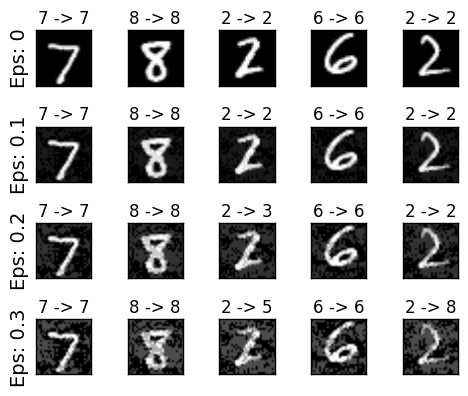

In [11]:
attack_display(epsilons[::2],cnn_examples[::2])

## Test LeNet-KNN's security capability 

In [12]:
knn_model_path="lenet-knn-poly-cp1-dp5/models/best_model.tar"
knn_sd=torch.load(knn_model_path)["model"]
knn.load_state_dict(knn_sd)
knn_accs,knn_examples=output_under_attack(knn,epsilons)

Epsilon 0:Test Accuracy 0.9876
Epsilon 0.05:Test Accuracy 0.8602
Epsilon 0.1:Test Accuracy 0.5762
Epsilon 0.15:Test Accuracy 0.3297
Epsilon 0.2:Test Accuracy 0.2086
Epsilon 0.25:Test Accuracy 0.1656
Epsilon 0.3:Test Accuracy 0.1546


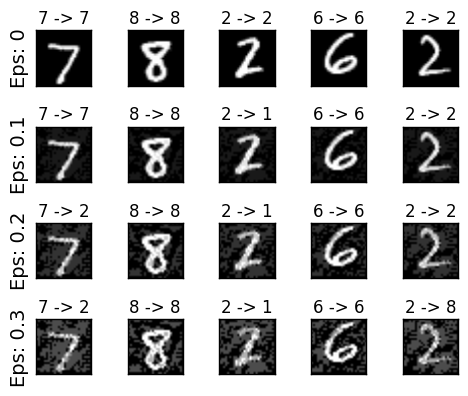

In [13]:
attack_display(epsilons[::2],knn_examples[::2])

## Display results

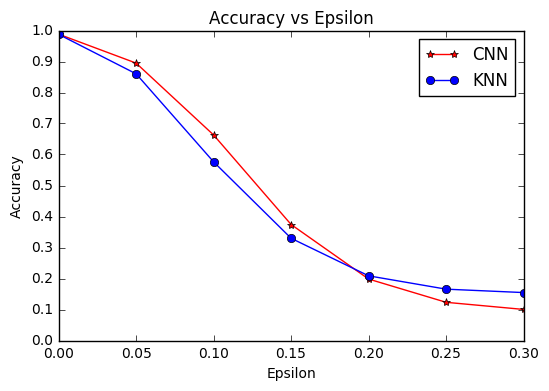

In [14]:
plt.plot(epsilons,cnn_accs,"*-",c="red",label="CNN")
plt.plot(epsilons,knn_accs,"o-",c="blue",label="KNN")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()